# 前処理

In [61]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

df = pd.read_csv('../../../mltestdata/SMSSpamCollection', sep='\t', names = ["label", "message"])
df['label'] = df['label'].map({'ham':0,'spam':1}).astype(int)

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(df['message'],df['label'],test_size=0.2,random_state=1)

In [63]:
tf_vectorizer = CountVectorizer()
tf_vectorizer.fit(X_train)
tf_vectorizer.vocabulary_

X_train= tf_vectorizer.transform(X_train)
X_test = tf_vectorizer.transform(X_test)

clf = MultinomialNB()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

* * * * * 

悲しいかな、性能評価で何が何を意味しているかわからないので、まとめる。。。

まず一言で言うと、__性能指標とは、y_testとy_predictを比較すること！__ のようです。

# 分類の評価方法編
* * * 
## Accuracy / Precision / Recall / f1
例は上記の迷惑メールフィルタを使います。これを理解するにはsklearn.metricsが大いに役立ちそう。
下の混同行列を例に考えるとよし。なので、先にこちらかを実行。

### (sklearn.metrics) confusion_matrix

In [44]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
confmat = confusion_matrix(y_test, y_pred)
print(confmat)

[[965   3]
 [  8 139]]


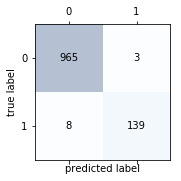

In [45]:
fig, ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j,y=i,s=confmat[i,j],va='center',ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

### (sklearn.metrics) accuracy_score / precision_score / recall_score / f1_score

In [55]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Accuracy score: ', format(accuracy_score(y_test, y_pred)))
print('Precision score: ', format(precision_score(y_test, y_pred)))
print('Recall score: ', format(recall_score(y_test, y_pred)))
print('F1 score: ', format(f1_score(y_test, y_pred)))

Accuracy score:  0.9901345291479821
Precision score:  0.9788732394366197
Recall score:  0.9455782312925171
F1 score:  0.9619377162629758


読み方注意。
- 縦に読むと、一行目が分類0、二行目が分類1を指している。
- 横に読むと、どこに誤って分類されてしまったかを見る。一行目は０に正しく965個分類できて、１に3個誤って分類された事がわかる。

この図を元にやりましょうか。

##### Accuracy
これは単純に正答率。　
1-誤分類率なので、誤分類率を求め手から、引き算。

```
     (3+8)/(965+3+8+139)=0.00986547
```

そして引き算。
```
     1 - 0.00986547 = 0.99013...
```
__(sklearn.metrics) accuracy_score__ で求める事ができる。


##### Precision
適合率と言う指標。陽性のクラスと予測したサンプルのうち、実際に陽性と判断されたものの割合。 
混同行列を使うと、Predictを中心に考える事。　Predictに対して、実際（True）はどうかな、と見ていく。

* ここ要注意だったのですが、関数に __The best value is 1 and the worst value is 0.__ と文言があるので、ライブラリを使って求めるので、混同行列のフォーカスは１の方にして、計算をします。

```
     (139)/(139+3) = 0.97887324
```

##### Recall
再現率という指標。
混同行列を使うと、Trueを中心に考える事。　Trueに対して、予測（Predict）はどうかな、と見ていく。

```
     (139)/(139+8) = 0.94557823
```

##### F1
適合率と再現率の調和平均している指標。確かPrecisionだけとか、Recallだけ、とかだと偏りが出ちゃうんだったような。

```
     F1 = 2 * (PRE * REC) / (PRE + REC)

     2 * (0.97887324 * 0.94557823) / (0.97887324 + 0.94557823) = 0.9619377158661894
```

おー、一緒だ。

あと注意点を以下に。

RecallやPrecisionを見る事になるが、実際にはどの評価関数を重要視するかが大事。

Recallの場合、True label大事になので、分類したい事（迷惑メールなど）をより検出することに、重きを置いているといえる。
Precisionの場合、Predicted label大事になので、逆に本来の分類（迷惑メールなど）がきちんと本来の分類に分ける事ができているかということに重きを置いている事になる、と。 

迷惑メールの場合、スパムで無いメールをスパムと認識しては困るので、Precisionを重要視するなど、評価する評価関数の使い分けが必要になってくる。


### (sklearn.metrics) classification_report

これも便利。

In [60]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.99      1.00      0.99       968
          1       0.98      0.95      0.96       147

avg / total       0.99      0.99      0.99      1115



* * * 
## 決定係数

相関係数がrで、その二乗が決定係数。1に近いほど、回帰直線の式が成立して、yはxから完全に __決定__ されるから決定係数なんですね。

* * *
## p値
一筋縄でわからないので、必要が出たら勉強します。

# ジニ係数

In [ ]:
def eval_gini(y_true, y_prob):
   y_true = np.asarray(y_true)
   y_true = y_true[np.argsort(y_prob)]
   ntrue = 0
   gini = 0
   delta = 0
   n = len(y_true)
   for i in range(n-1, -1, -1):
       y_i = y_true[i]
       ntrue += y_i
       gini += y_i * delta
       delta += 1 - y_i
   gini = 1 - 2 * gini / (ntrue * (n - ntrue))
   return gini

# RMSE

In [ ]:
def eval_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# RMSLE

In [ ]:
def rmsle(y_pred, y_true):
    return np.sqrt(np.square(np.log(y_true + 1) - np.log(y_pred + 1)).mean())

def RMSLE(y, pred):
    return mean_squared_error(y, pred)**0.5


# A function to calculate Root Mean Squared Logarithmic Error (RMSLE)
# https://www.kaggle.com/marknagelberg/caterpillar-tube-pricing/rmsle-function
def rmsle(y, y_pred):
	assert len(y) == len(y_pred)
	terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
	return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5


# YieFan

Personally, I am doing a bit more than this, I do this:

First of all, introduce a new feature, and then do the following evaluation:
Do this 20 times with different random setting:
1. Train_test_split (70%/30%) -> local train (70% of original train), local val (30% of original train)
2. Perform 5-fold CV on local train(70% of original train) -> generate out-of-fold prediction for local train (70% of original train) and local validation (30% of original train)
3. Calculate AUC/Gini with (Y of local val, oof prediction of local val) -> Validation score for the local val (30% of original train)

As I said above,  I repeat steps 1-2-3 20 times, and then I average the validation scores of (output of step 3).

Now if the validation score improve compare to the validation score for data without the new feature, I proceed to second round of validation, this time I for the train_test_split with (50%/50%) setting.

Only features that improve validation score in both rounds i.e. (70%/30%) and (50%/50%) setting, I will consider them to be useful 

So far, none of the features share on the kernel pass this test:joy:
Maybe I am being too strict, but I am gonna stick with it -> there is always the next competition!

I am doing it this way also partly because I have a good work station, so if your laptop/PC is too slow to do this, just do simple repeated k-fold 